### Exercice 1

In [1]:
# Imports General
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
import matplotlib

In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler


In [3]:
import csv
import math
import scipy.ndimage as nd
from scipy.stats.mstats import mquantiles, kurtosis, skew
from sklearn.preprocessing import LabelEncoder


In [5]:
# Import OpenCV
import cv2


In [6]:
train_path='C:/Users/RyanM/Desktop/Python Lab/Lab0/images_training/'
#valid_path='images/'


In [7]:
# Let's read each image filename in out list and store the corresponding image 
# Name to each class as X_train. Also, store the labels of galaxies as 1  and 0.
#
csvFile = open("GTI770_label_data_set.csv", "r")
count = 0

Y = np.ones(10000 , dtype=str)
X = [''] * 10000
choices = {'spiral' : 1, 'smooth': 0}
tic = time.time()
for i in csvFile:
    id_, name = i.split(',')
    if id_ != "id":
        imagePath = train_path + id_ + '.jpg'
        if not os.path.exists(imagePath):
            continue
        #print('imagePath exists', count)
        X[count] = id_ + '.jpg'
        Y[count]=  choices.get(name.rstrip(), 99)
        count += 1
        if count == 10000:
            break
print('Completed in', (time.time() - tic))

Completed in 2.527144432067871


In [8]:
#La matrice X a été divisée en 2 matrices avec un ratio de 70% (X_train)
#et 30% (X_test). Aussi, la matrice Y a été divisée en deux matrices de Y_train et Y_test.

from sklearn.model_selection import train_test_split
X_train, X_test1, Y_train, Y_test1 = train_test_split(X, Y, test_size=0.4,stratify=Y)

In [9]:
X_test, X_validation, Y_test, Y_validation = train_test_split(X_test1, Y_test1, test_size=0.5,stratify=Y_test1) 

In [10]:
''' Create empty feature vectors to store the features that we will extract from images
feature #1: Maximum values of Red and Blue channels for cropped image of 64 x 64
feature #2: Red to Blue color intensity ratio for cropped image of 64 x 64
feature #3: Black to White pixel ratio for cropped image of 64 x 64

In the feature_vector, the first two columns are maximum red and maximum blue color
and in the third column, 
'''
num_features = 6

# If we want to add the label at the end of the feature vector, we must add a dimension
num_features = num_features + 1
# This array lives on the GPU since we passed the gpu_device context
feature_vector_train = np.zeros( (len(X_train), num_features))
feature_vector_test = np.zeros( (len(X_test), num_features))


In [24]:
img_count = 0

# Loop for each image in the list
for file_name in X_train:
    # Read the image
    img_color = cv2.imread(train_path+file_name,-1)
        # Create a gray scale of image
    img_grey=cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)  
    ret,img_binary = cv2.threshold(img_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # create a matrix to store color RGB pixels of each image
    colorMatrix=np.ones((4096,2),dtype=int)
        # Initialize variables with zero 
    n_white_pix=0
    n_black_pix=0
    index=0
    print ("Processing image " +str(img_count+1)+" "+file_name ) 
        
    # Feature 1 start #############################################################
    # Loop that reads each image pixel
    # =============================================================================
    #     for i in range(187,237):
    #         for j in range(187,237):
    # =============================================================================
    for i in range(180,244):
          for j in range(180,244):     
                red = img_color[i][j][2]
                gre = img_color[i][j][1]
                blu = img_color[i][j][0]
                colorMatrix[index,0]=red
                colorMatrix[index,1]=blu
                index+=1              
                if img_binary[i,j]==255:
                    n_white_pix+=1
                else:
                    n_black_pix+=1
    # Store the features values in the columns of the feature (matrix) vector
    # feature 1, 2, 3 and 4
    redColumnAverage=np.mean(colorMatrix[:,0]) #mean of red colmun
    blueColumnAverage=np.mean(colorMatrix[:,1]) #mean of blue colmun   
    red2blueRatio=redColumnAverage/blueColumnAverage  # ratio of red to blue for each image          
    black2whitePixelRatio=n_black_pix/n_white_pix # ratio of black pixel number to white pixel number
    
    # Feature Morphology ###################################
    img_blurred=cv2.pyrMeanShiftFiltering(img_color,61,181)
    
    img_grey=cv2.cvtColor(img_blurred,cv2.COLOR_BGR2GRAY)
    ret,img_binary_grey = cv2.threshold(img_grey,245,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _,contours,_=cv2.findContours(img_binary_grey,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img_color,contours,-1,(130,255,255),3)
        
    ## find best contour for image
    best_contour_ma = 0
    best_contour_MA = 0

    for i, contour in enumerate(contours):
        try: 
            (x,y),(MA,ma),angle=cv2.fitEllipse(contour)
        
            print("Contour", i)

            if (MA * ma > best_contour_ma * best_contour_MA):
                best_contour_ma = ma
                best_contour_MA = MA
        except:
            print('Couldn\'t fit ellipse from contour');
            
    if best_contour_ma == 0 or best_contour_MA == 0:
        maByMa = -1
        print('Tried all contours and none of them could fit ellipse')
    else:
        maByMA = best_contour_ma/best_contour_MA

    feature_vector_train[img_count] = [np.max(colorMatrix[:,0]), np.max(colorMatrix[:,1]),red2blueRatio,black2whitePixelRatio, maByMA, angle, Y_train[img_count]]
  
    img_count += 1
    
    # Save the extracted feature vector into a text file.
    np.savetxt("feature_vector_train.csv", feature_vector_train, delimiter=",")
        
print("Feature extraction ended successfully")

Processing image 1 218281.jpg
Couldn't fit ellipse from contour
Contour 1
Processing image 2 158512.jpg
Contour 0
Processing image 3 183259.jpg
Contour 0
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Contour 3
Contour 4
Processing image 4 142257.jpg
Couldn't fit ellipse from contour
Contour 1
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Contour 5
Processing image 5 523496.jpg
Couldn't fit ellipse from contour
Contour 1
Processing image 6 319333.jpg
Contour 0
Processing image 7 128799.jpg
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Contour 3
Couldn't fit ellipse from contour
Contour 5
Contour 6
Contour 7
Processing image 8 136929.jpg
Couldn't fit ellipse from contour
Contour 1
Contour 2
Processing image 9 417028.jpg
Contour 0
Processing image 10 458062.jpg
Contour 0
Contour 1
Contour 2
Contour 3
Contour 4
Contour 5
Processing image 11 346053.jpg
Contou

In [14]:
## Same thing, but for test data
img_count = 0

# Loop for each image in the list
for file_name in X_test:
    # Read the image
    img_color = cv2.imread(train_path+file_name,-1)
        # Create a gray scale of image
    img_grey=cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)  
    ret,img_binary = cv2.threshold(img_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # create a matrix to store color RGB pixels of each image
    colorMatrix=np.ones((4096,2),dtype=int)
        # Initialize variables with zero 
    n_white_pix=0
    n_black_pix=0
    index=0
    print ("Processing image " +str(img_count+1)+" "+file_name ) 

    for i in range(180,244):
          for j in range(180,244):     
                red = img_color[i][j][2]
                gre = img_color[i][j][1]
                blu = img_color[i][j][0]
                colorMatrix[index,0]=red
                colorMatrix[index,1]=blu
                index+=1              
                if img_binary[i,j]==255:
                    n_white_pix+=1
                else:
                    n_black_pix+=1
    # Store the features values in the columns of the feature (matrix) vector
    # feature 1, 2, 3 and 4
    redColumnAverage=np.mean(colorMatrix[:,0]) #mean of red colmun
    blueColumnAverage=np.mean(colorMatrix[:,1]) #mean of blue colmun   
    red2blueRatio=redColumnAverage/blueColumnAverage  # ratio of red to blue for each image          
    black2whitePixelRatio=n_black_pix/n_white_pix # ratio of black pixel number to white pixel number
    
    # Feature Morphology ###################################
    img_blurred=cv2.pyrMeanShiftFiltering(img_color,61,181)
    
    img_grey=cv2.cvtColor(img_blurred,cv2.COLOR_BGR2GRAY)
    ret,img_binary_grey = cv2.threshold(img_grey,245,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _,contours,_=cv2.findContours(img_binary_grey,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img_color,contours,-1,(130,255,255),3)
        
    ## find best contour for image
    best_contour_ma = 0
    best_contour_MA = 0

    for i, contour in enumerate(contours):
        try: 
            (x,y),(MA,ma),angle=cv2.fitEllipse(contour)
        
            print("Contour", i)

            if (MA * ma > best_contour_ma * best_contour_MA):
                best_contour_ma = ma
                best_contour_MA = MA
        except:
            print('Couldn\'t fit ellipse from contour');
            
    if best_contour_ma == 0 or best_contour_MA == 0:
        maByMa = -1
        print('Tried all contours and none of them could fit ellipse')
    else:
        maByMA = best_contour_ma/best_contour_MA

    feature_vector_test[img_count] = [np.max(colorMatrix[:,0]), np.max(colorMatrix[:,1]),red2blueRatio,black2whitePixelRatio, maByMA, angle, Y_test[img_count]]
  
    img_count += 1
    
    # Save the extracted feature vector into a text file.
    np.savetxt("feature_vector_test.csv", feature_vector_test, delimiter=",")
        
print("Feature extraction ended successfully")

Processing image 1 389201.jpg
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Contour 10
Contour 11
Couldn't fit ellipse from contour
Contour 13
Processing image 2 594580.jpg
Couldn't fit ellipse from contour
Contour 1
Processing image 3 321723.jpg
Contour 0
Contour 1
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Contour 4
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Contour 8
Processing image 4 503392.jpg
Contour 0
Processing image 5 348402.jpg
Contour 0
Couldn't fit ellipse from contour
Processing image 6 531632.jpg
Contour 0
Couldn't fit ellipse from contour
Contour 2
Processing image 7 219187.jpg
Contour 0
Contour 1
P

In [15]:
## Same thing, but for Validation data
img_count = 0

# Loop for each image in the list
for file_name in X_validation:
    # Read the image
    img_color = cv2.imread(train_path+file_name,-1)
        # Create a gray scale of image
    img_grey=cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)  
    ret,img_binary = cv2.threshold(img_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # create a matrix to store color RGB pixels of each image
    colorMatrix=np.ones((4096,2),dtype=int)
        # Initialize variables with zero 
    n_white_pix=0
    n_black_pix=0
    index=0
    print ("Processing image " +str(img_count+1)+" "+file_name ) 

    for i in range(180,244):
          for j in range(180,244):     
                red = img_color[i][j][2]
                gre = img_color[i][j][1]
                blu = img_color[i][j][0]
                colorMatrix[index,0]=red
                colorMatrix[index,1]=blu
                index+=1              
                if img_binary[i,j]==255:
                    n_white_pix+=1
                else:
                    n_black_pix+=1
    # Store the features values in the columns of the feature (matrix) vector
    # feature 1, 2, 3 and 4
    redColumnAverage=np.mean(colorMatrix[:,0]) #mean of red colmun
    blueColumnAverage=np.mean(colorMatrix[:,1]) #mean of blue colmun   
    red2blueRatio=redColumnAverage/blueColumnAverage  # ratio of red to blue for each image          
    black2whitePixelRatio=n_black_pix/n_white_pix # ratio of black pixel number to white pixel number
    
    # Feature Morphology ###################################
    img_blurred=cv2.pyrMeanShiftFiltering(img_color,61,181)
    
    img_grey=cv2.cvtColor(img_blurred,cv2.COLOR_BGR2GRAY)
    ret,img_binary_grey = cv2.threshold(img_grey,245,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _,contours,_=cv2.findContours(img_binary_grey,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img_color,contours,-1,(130,255,255),3)
        
    ## find best contour for image
    best_contour_ma = 0
    best_contour_MA = 0

    for i, contour in enumerate(contours):
        try: 
            (x,y),(MA,ma),angle=cv2.fitEllipse(contour)
        
            print("Contour", i)

            if (MA * ma > best_contour_ma * best_contour_MA):
                best_contour_ma = ma
                best_contour_MA = MA
        except:
            print('Couldn\'t fit ellipse from contour');
            
    if best_contour_ma == 0 or best_contour_MA == 0:
        maByMa = -1
        print('Tried all contours and none of them could fit ellipse')
    else:
        maByMA = best_contour_ma/best_contour_MA

    feature_vector_test[img_count] = [np.max(colorMatrix[:,0]), np.max(colorMatrix[:,1]),red2blueRatio,black2whitePixelRatio, maByMA, angle, Y_validation[img_count]]
  
    img_count += 1
    
    # Save the extracted feature vector into a text file.
    np.savetxt("feature_vector_validation.csv", feature_vector_test, delimiter=",")
        
print("Feature extraction ended successfully")

Processing image 1 238795.jpg
Couldn't fit ellipse from contour
Contour 1
Processing image 2 304928.jpg
Contour 0
Couldn't fit ellipse from contour
Contour 2
Couldn't fit ellipse from contour
Processing image 3 141973.jpg
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Contour 2
Couldn't fit ellipse from contour
Contour 4
Processing image 4 160999.jpg
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Contour 3
Contour 4
Processing image 5 464489.jpg
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Couldn't fit ellipse from contour
Contour 9
Contour 10
Couldn't fit ellipse from contour
Contour 12
Contour 13
Processing image 6 135338.jpg
Contour 0
Contour 1
Processing image 7 399489.jpg
Contour 0
C

C:\Users\RyanM\Anaconda3\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "l". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


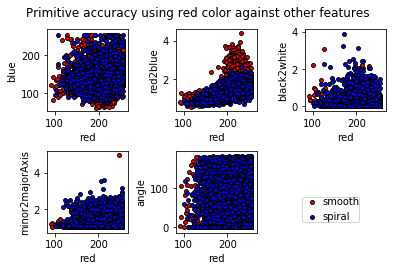

In [20]:
# Evaluation des primitives
# Parameters
n_classes = 2
plot_colors = "rb"
plot_step = 0.02
feature_names=['red','blue','red2blue','black2white','minor2majorAxis','angle']
# Load data
iris =np.loadtxt("feature_vector_train.csv", delimiter=",")
target_names=["smooth", "spiral"]
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], 
                                [0, 4], [0, 5]]):
    # We only take the two corresponding features
    X = iris[:, pair]
    y = iris[:,6]

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)
   # f, axs = plt.subplots(2,3,pairidx + 1,figsize=(10,10))
    
    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
        plt.xlabel(feature_names[pair[0]])
        plt.ylabel(feature_names[pair[1]])
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
       

plt.suptitle("Primitive accuracy using red color against other features")
plt.legend(loc="l", bbox_to_anchor=(1.5,0.5), borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

C:\Users\RyanM\Anaconda3\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "l". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


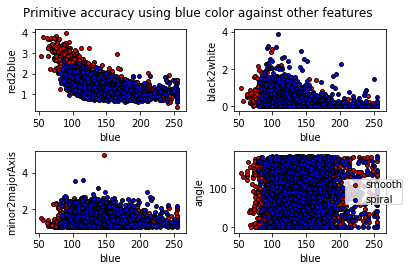

In [16]:

for pairidx, pair in enumerate([[1, 2], [1, 3], [1, 4], [1, 5]]):
    
    # We only take the two corresponding features
    X = iris[:, pair]
    y = iris[:,6]

    # Plot the decision boundary
    plt.subplot(2, 2, pairidx + 1)
   # f, axs = plt.subplots(2,3,pairidx + 1,figsize=(10,10))
    
    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
        plt.xlabel(feature_names[pair[0]])
        plt.ylabel(feature_names[pair[1]])
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
       

plt.suptitle("Primitive accuracy using blue color against other features")
plt.legend(loc="l", bbox_to_anchor=(0.7,0.5), borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

C:\Users\RyanM\Anaconda3\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "l". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


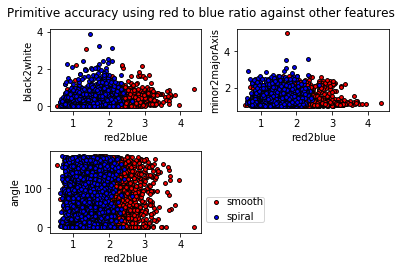

In [21]:
for pairidx, pair in enumerate([
                                [2, 3], [2, 4], [2, 5]]):
    # We only take the two corresponding features
    X = iris[:, pair]
    y = iris[:,6]

    # Plot the decision boundary
    plt.subplot(2, 2, pairidx + 1)
   # f, axs = plt.subplots(2,3,pairidx + 1,figsize=(10,10))
    
    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
        plt.xlabel(feature_names[pair[0]])
        plt.ylabel(feature_names[pair[1]])
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
       

plt.suptitle("Primitive accuracy using red to blue ratio against other features")
plt.legend(loc="l", bbox_to_anchor=(1,0.5), borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

C:\Users\RyanM\Anaconda3\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "l". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


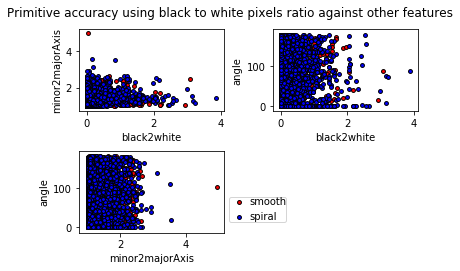

In [18]:
for pairidx, pair in enumerate([
                                [3, 4], [3, 5],
                                [4, 5]]):
    # We only take the two corresponding features
    X = iris[:, pair]
    y = iris[:,6]

    # Plot the decision boundary
    plt.subplot(2, 2, pairidx + 1)
   # f, axs = plt.subplots(2,3,pairidx + 1,figsize=(10,10))
    
    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
        plt.xlabel(feature_names[pair[0]])
        plt.ylabel(feature_names[pair[1]])
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
       

plt.suptitle("Primitive accuracy using black to white pixels ratio against other features")
plt.legend(loc="l", bbox_to_anchor=(1,0.5), borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

In [22]:
# to visualize the tree you must install this library
# conda install python-graphviz OR pip install graphviz
import graphviz
from sklearn import tree

In [23]:

# Load data from file
# File with 4 features extracted from galaxies
num_features = 6
data_train = np.loadtxt("feature_vector_train.csv", delimiter=",")
data_test = np.loadtxt("feature_vector_test.csv", delimiter=",")
data_validation = np.loadtxt("feature_vector_validation.csv", delimiter=",")

In [24]:

# Define the training set
# Just for two classes (Smooth=0 and Spiral =1)

X_train  = data_train[:,0:num_features]
Y_train  = data_train[:,num_features]

X_test  = data_test[:,0:num_features]
Y_test  = data_test[:,num_features]

X_validation  = data_validation[:,0:num_features]
Y_validation  = data_validation[:,num_features]

In [25]:
# Train the Decision Tree with the training set max_depth 7
model_depth7 = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10, max_depth=7)
model_depth7 = model_depth7.fit(X_train, Y_train)

feature_names = ['red', 'blue', 'ratio_red2blue', 'ration_black2whitePixel', 'ma/MA', 'angle']

dot_data = tree.export_graphviz(model_depth7, out_file=None, 
                         feature_names=feature_names,
                         class_names = ['Smooth', 'Spiral'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render("SpiralGalaxy_Data", view=True) 
graph 

# predict the class of samples
# train dataset
Y_test_pred_max_depth7 = model_depth7.predict(X_test)


# predict the probability of each class
# train dataset

Y_test_pred_prob_max_depth7 = model_depth7.predict_proba(X_test)


# predict the class of samples
# train dataset
Y_validation_pred_max_depth7 = model_depth7.predict(X_validation)


# predict the probability of each class
# train dataset

Y_validation_pred_prob_max_depth7 = model_depth7.predict_proba(X_validation)

In [26]:
# Train the Decision Tree with the training set max_depth 5
model_depth5 = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10, max_depth=5)
model_depth5 = model_depth5.fit(X_train, Y_train)


dot_data = tree.export_graphviz(model_depth5, out_file=None, 
                         feature_names=feature_names,
                         class_names = ['Smooth', 'Spiral'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render("SpiralGalaxy_Data", view=True) 
graph 

# predict the class of samples
# train dataset
Y_test_pred_max_depth5 = model_depth5.predict(X_test)


# predict the probability of each class
# train dataset

Y_test_pred_prob_max_depth5 = model_depth5.predict_proba(X_test)

# predict the class of samples
# train dataset
Y_validation_pred_max_depth5 = model_depth5.predict(X_validation)


# predict the probability of each class
# train dataset

Y_validation_pred_prob_max_depth5 = model_depth5.predict_proba(X_validation)

In [27]:
# Train the Decision Tree with the training set max_depth 3
model_depth3 = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10, max_depth=3)
model_depth3 = model_depth3.fit(X_train, Y_train)


dot_data = tree.export_graphviz(model_depth3, out_file=None, 
                         feature_names=feature_names,
                         class_names = ['Smooth', 'Spiral'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render("SpiralGalaxy_Data", view=True) 
graph 

# predict the class of samples
# train dataset
Y_test_pred_max_depth3 = model_depth3.predict(X_test)


# predict the probability of each class
# train dataset

Y_test_pred_prob_max_depth3 = model_depth3.predict_proba(X_test)

Y_validation_pred_max_depth3 = model_depth3.predict(X_validation)


# predict the probability of each class
# train dataset

Y_validation_pred_prob_max_depth3 = model_depth3.predict_proba(X_validation)

In [31]:
# Train the Decision Tree with the training set max_depth 2
model_depth2 = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10, max_depth=2)
model_depth2 = model_depth2.fit(X_train, Y_train)


dot_data = tree.export_graphviz(model_depth2, out_file=None, 
                         feature_names=feature_names,
                         class_names = ['Smooth', 'Spiral'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render("SpiralGalaxy_Data", view=True) 
graph 

# predict the class of samples
# train dataset
Y_test_pred_max_depth2 = model_depth2.predict(X_test)


# predict the probability of each class
# train dataset

Y_test_pred_prob_max_depth2 = model_depth2.predict_proba(X_test)

# predict the class of samples
# train dataset
Y_validation_pred_max_depth2 = model_depth2.predict(X_validation)


# predict the probability of each class
# train dataset

Y_validation_pred_prob_max_depth2 = model_depth2.predict_proba(X_validation)

In [32]:
# evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [33]:
acc_galaxy_test_max_depth7 = accuracy_score(Y_test, Y_test_pred_max_depth7 )
print("Correct classification rate for test dataset with max depth 7 = "+str(acc_galaxy_test_max_depth7*100)+"%")

acc_galaxy_test_max_depth5 = accuracy_score(Y_test, Y_test_pred_max_depth5 )
print("Correct classification rate for test dataset with max depth 5 = "+str(acc_galaxy_test_max_depth5*100)+"%")

acc_galaxy_test_max_depth3 = accuracy_score(Y_test, Y_test_pred_max_depth3 )
print("Correct classification rate for test dataset with max depth 3 = "+str(acc_galaxy_test_max_depth3*100)+"%")

acc_galaxy_test_max_depth2 = accuracy_score(Y_test, Y_test_pred_max_depth2 )
print("Correct classification rate for test dataset with max depth 3 = "+str(acc_galaxy_test_max_depth2*100)+"%")


acc_galaxy_validation_max_depth7 = accuracy_score(Y_validation, Y_validation_pred_max_depth7 )
print("Correct classification rate for validation dataset with max depth 7 = "+str(acc_galaxy_validation_max_depth7*100)+"%")

acc_galaxy_validation_max_depth5 = accuracy_score(Y_validation, Y_validation_pred_max_depth5 )
print("Correct classification rate for validation dataset with max depth 5 = "+str(acc_galaxy_validation_max_depth5*100)+"%")

acc_galaxy_validation_max_depth3 = accuracy_score(Y_validation, Y_validation_pred_max_depth3 )
print("Correct classification rate for validation dataset with max depth 3 = "+str(acc_galaxy_validation_max_depth3*100)+"%")

acc_galaxy_validation_max_depth2 = accuracy_score(Y_validation, Y_validation_pred_max_depth2 )
print("Correct classification rate for validation dataset with max depth 3 = "+str(acc_galaxy_validation_max_depth2*100)+"%")

Correct classification rate for test dataset with max depth 7 = 87.9%
Correct classification rate for test dataset with max depth 5 = 87.1%
Correct classification rate for test dataset with max depth 3 = 82.1%
Correct classification rate for test dataset with max depth 3 = 76.8%
Correct classification rate for validation dataset with max depth 7 = 87.8%
Correct classification rate for validation dataset with max depth 5 = 86.45%
Correct classification rate for validation dataset with max depth 3 = 82.45%
Correct classification rate for validation dataset with max depth 3 = 76.55%


In [34]:
from sklearn.metrics import classification_report

In [35]:
target_names = ['Smooth', 'Spiral']
print( classification_report(Y_test, Y_test_pred_max_depth7, target_names=target_names))

cm_galaxy_test_max_depth7 = confusion_matrix(Y_test, Y_test_pred_max_depth7 )

print( classification_report(Y_test, Y_test_pred_max_depth5, target_names=target_names))

cm_galaxy_test_max_depth5 = confusion_matrix(Y_test, Y_test_pred_max_depth5 )

print( classification_report(Y_test, Y_test_pred_max_depth3, target_names=target_names))

cm_galaxy_test_max_depth3 = confusion_matrix(Y_test, Y_test_pred_max_depth3 )

print( classification_report(Y_test, Y_test_pred_max_depth2, target_names=target_names))

cm_galaxy_test_max_depth2 = confusion_matrix(Y_test, Y_test_pred_max_depth2 )

print( classification_report(Y_validation, Y_validation_pred_max_depth7, target_names=target_names))

cm_galaxy_validation_max_depth7 = confusion_matrix(Y_validation, Y_validation_pred_max_depth7 )

print( classification_report(Y_validation, Y_validation_pred_max_depth5, target_names=target_names))

cm_galaxy_validation_max_depth5 = confusion_matrix(Y_validation, Y_validation_pred_max_depth5 )

print( classification_report(Y_validation, Y_validation_pred_max_depth3, target_names=target_names))

cm_galaxy_validation_max_depth3 = confusion_matrix(Y_validation, Y_validation_pred_max_depth3 )

print( classification_report(Y_validation, Y_validation_pred_max_depth2, target_names=target_names))

cm_galaxy_validation_max_depth2 = confusion_matrix(Y_validation, Y_validation_pred_max_depth2 )

             precision    recall  f1-score   support

     Smooth       0.87      0.88      0.87       950
     Spiral       0.89      0.88      0.88      1050

avg / total       0.88      0.88      0.88      2000

             precision    recall  f1-score   support

     Smooth       0.88      0.85      0.86       950
     Spiral       0.87      0.89      0.88      1050

avg / total       0.87      0.87      0.87      2000

             precision    recall  f1-score   support

     Smooth       0.81      0.81      0.81       950
     Spiral       0.83      0.83      0.83      1050

avg / total       0.82      0.82      0.82      2000

             precision    recall  f1-score   support

     Smooth       0.76      0.76      0.76       950
     Spiral       0.78      0.78      0.78      1050

avg / total       0.77      0.77      0.77      2000

             precision    recall  f1-score   support

     Smooth       0.87      0.87      0.87       951
     Spiral       0.88      0.89 

In [36]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[832 118]
 [124 926]]
Confusion matrix, without normalization
[[807 143]
 [115 935]]
Confusion matrix, without normalization
[[771 179]
 [179 871]]
Confusion matrix, without normalization
[[719 231]
 [233 817]]
Normalized confusion matrix
[[ 0.88  0.12]
 [ 0.12  0.88]]
Normalized confusion matrix
[[ 0.85  0.15]
 [ 0.11  0.89]]
Normalized confusion matrix
[[ 0.81  0.19]
 [ 0.17  0.83]]
Normalized confusion matrix
[[ 0.76  0.24]
 [ 0.22  0.78]]


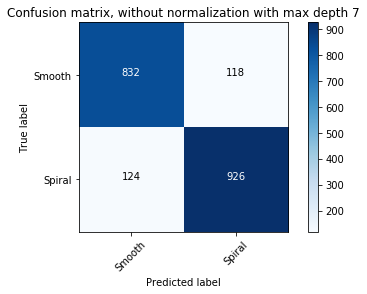

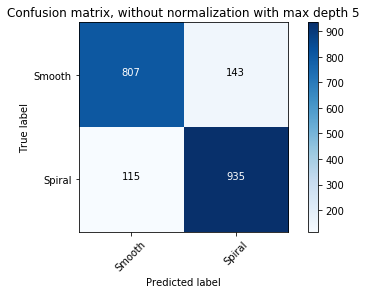

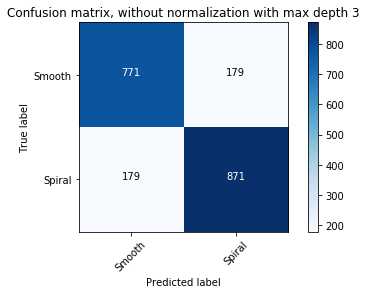

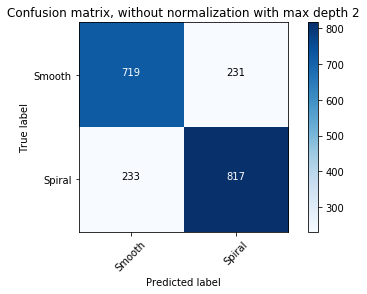

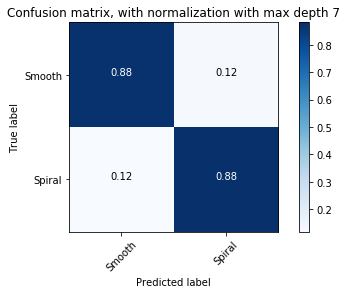

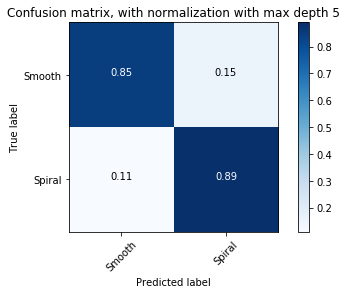

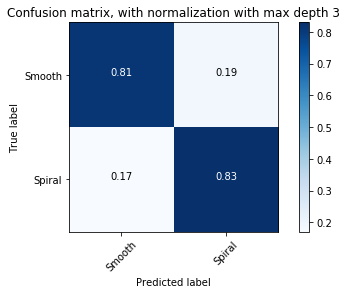

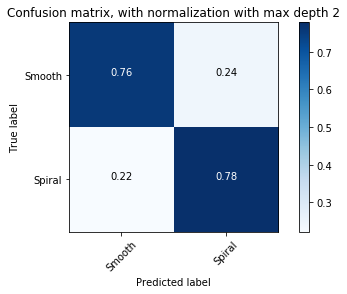

In [37]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix for max depth =7
plt.figure()
plot_confusion_matrix(cm_galaxy_test_max_depth7, classes= ['Smooth', 'Spiral'],
                      title='Confusion matrix, without normalization with max depth 7')

# Plot non-normalized confusion matrix for max depth =5
plt.figure()
plot_confusion_matrix(cm_galaxy_test_max_depth5, classes= ['Smooth', 'Spiral'],
                      title='Confusion matrix, without normalization with max depth 5')

# Plot non-normalized confusion matrix for max depth =3
plt.figure()
plot_confusion_matrix(cm_galaxy_test_max_depth3, classes= ['Smooth', 'Spiral'],
                      title='Confusion matrix, without normalization with max depth 3')

# Plot non-normalized confusion matrix for max depth =2
plt.figure()
plot_confusion_matrix(cm_galaxy_test_max_depth2, classes= ['Smooth', 'Spiral'],
                      title='Confusion matrix, without normalization with max depth 2')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_galaxy_test_max_depth7, classes= ['Smooth', 'Spiral'], normalize=True,
                      title='Confusion matrix, with normalization with max depth 7')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_galaxy_test_max_depth5, classes= ['Smooth', 'Spiral'], normalize=True,
                      title='Confusion matrix, with normalization with max depth 5')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_galaxy_test_max_depth3, classes= ['Smooth', 'Spiral'], normalize=True,
                      title='Confusion matrix, with normalization with max depth 3')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_galaxy_test_max_depth2, classes= ['Smooth', 'Spiral'], normalize=True,
                      title='Confusion matrix, with normalization with max depth 2')
plt.show()

In [2]:
# Plot non-normalized confusion matrix for max depth =7
plt.figure()
plot_confusion_matrix(cm_galaxy_validation_max_depth7, classes= ['Smooth', 'Spiral'],
                      title='Confusion matrix, without normalization with max depth 7')

# Plot non-normalized confusion matrix for max depth =5
plt.figure()
plot_confusion_matrix(cm_galaxy_validation_max_depth5, classes= ['Smooth', 'Spiral'],
                      title='Confusion matrix, without normalization with max depth 5')

# Plot non-normalized confusion matrix for max depth =3
plt.figure()
plot_confusion_matrix(cm_galaxy_validation_max_depth3, classes= ['Smooth', 'Spiral'],
                      title='Confusion matrix, without normalization with max depth 3')

# Plot non-normalized confusion matrix for max depth =2
plt.figure()
plot_confusion_matrix(cm_galaxy_validation_max_depth2, classes= ['Smooth', 'Spiral'],
                      title='Confusion matrix, without normalization with max depth 2')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_galaxy_validation_max_depth7, classes= ['Smooth', 'Spiral'], normalize=True,
                      title='Confusion matrix, with normalization with max depth 7')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_galaxy_validation_max_depth5, classes= ['Smooth', 'Spiral'], normalize=True,
                      title='Confusion matrix, with normalization with max depth 5')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_galaxy_validation_max_depth3, classes= ['Smooth', 'Spiral'], normalize=True,
                      title='Confusion matrix, with normalization with max depth 3')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_galaxy_validation_max_depth2, classes= ['Smooth', 'Spiral'], normalize=True,
                      title='Confusion matrix, with normalization with max depth 2')
plt.show()


NameError: name 'plt' is not defined

In [41]:
# Parameters
n_classes = 2
plot_colors = "rb"
plot_step = 0.02
feature_names=['red','blue','red2blue','black2white','minor2majorAxis','angle']
# Load data
iris =np.loadtxt("feature_vector_train.csv", delimiter=",")
target_names=["smooth", "spiral"]
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [0, 4], [0, 5],
                                 ]):

    # We only take the two corresponding features
    X = iris[:, pair]
    y = iris[:,6]
    
    
    clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10, max_depth=7)
    clf = clf.fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)
   
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(feature_names[pair[0]])
    plt.ylabel(feature_names[pair[1]])
    # Plot the training points
    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()


MemoryError: 

In [ ]:
for pairidx, pair in enumerate([ [1, 2], [1, 3], [1, 4], [1, 5]]):

    # We only take the two corresponding features
    X = iris[:, pair]
    y = iris[:,6]
    
    
    clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10, max_depth=7)
    clf = clf.fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)
   
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(feature_names[pair[0]])
    plt.ylabel(feature_names[pair[1]])
    # Plot the training points
    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

In [ ]:
for pairidx, pair in enumerate([ [2, 3], [2, 4], [2, 5],
                                 [3, 4], [3, 5],
                                 [4, 5]]):

    # We only take the two corresponding features
    X = iris[:, pair]
    y = iris[:,6]
    
    
    clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10, max_depth=7)
    clf = clf.fit(X, y)

    # Plot the decision boundary
    plt.subplot(3, 3, pairidx + 1)
   
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(feature_names[pair[0]])
    plt.ylabel(feature_names[pair[1]])
    # Plot the training points
    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

Question 1: Avec les liens fournis en l’annexe de cet énoncé et avec vos trouvailles faites sur Internet par le biais de vos recherches personnelles, faites, à titre d’introduction, une revue de la littérature. Celle-ci doit faire état des recherches ayant été faites en la matière et des possibles pistes que vous pourriez suivre durant ce laboratoire pour effectuer l’extraction de primitives sur les images de galaxies.
La classification des galaxies date depuis déjà quelque temps. En effet, en 2007, un projet nommé “Galaxy Zoo” a été démarré avec le but de se servir du public pour aider des scientifiques à déterminer si certaines images prises par un télescope contenaient une galaxie de type spirale ou non-spirale. Des volontaires, situés partout sur la planète, se sont mis à classifier une à une les galaxies, surprenant les scientifiques qui croyaient avoir à faire tout cela eux mêmes. Cependant, les erreurs humaines et des opinions différentes sur ce qu’était une galaxie spirale versus une galaxie non-spirale a remis en question la possibilité de se servir entièrement du public pour classifier les images. 

La puissance de calcul augmentant exponentiellement, l’apprentissage machine est devenue un nouvelle solution pour classifier la grande quantité d’images capturées par le télescope. Plusieurs chercheurs se sont mis à essayer de trouver la meilleure combinaison de primitives possibles pour obtenir le plus haut taux de bonne classification. Il y a certaines primitives qui ressortent plus que d’autres pour différencier les galaxies. Par exemple, les couleurs de celles-ci ainsi que leurs formes permettent une bonne distinction des classes de galaxies.

La thèse “Morphological classification of galaxies into spirals and non-spirals“ d’un étudiant à la maîtrise à l’Université de l’Indiana met très bien en lumière quelles primitives aident à distinguer les galaxies spirales des non-spirales. En se basant sur cette thèse, l’équipe pourra tirer les primitives qui distinguent davantage les galaxies spirales des galaxies smooth. Il faudra aussi effectuer un pré-traitement sur les images afin de réduire le bruit avant l’extraction de leurs primitives. Ces images pré-traitées pourront alors être utilisées pour extraire leurs primitives et sauvegarder les résultats dans un fichier .csv. Pour ce qui est de l’extraction des primitives, les valeurs RGB des pixels seront utilisées pour calculer les résultats des primitives.


Question 2: Expliquer le choix des primitives. Quelle démarche avez-vous suivie afin d’effectuer votre choix de primitives? Sur quelles sources vous êtes-vous basées afin d’établir votre choix de primitives? 
Pour débuter, nous avons regardé un ensemble d’images sur une grille pour voir s’il y avait des discriminants interclasses faciles à trouver. Rapidement, nous avons aperçu que les galaxies classifiés comme spirales avaient souvent un teint plus bleu alors que les galaxies smooth avait un teint plus orange. 

Nous avons ensuite lues les publications qui étaient dans la section “référence” de l’énoncé. Nous avons trouvé le 2e particulièrement facile à lire et à comprendre. La section 1.4.7 et 1.4.11 venait confirmer qu’il était possible de différencier les deux types avec la couleur. Nous avons donc choisies ces primitives, car nous avions déjà un exemple d’algorithme d’extraction du nombre de pixel d’une image alors l’implémentation allait pouvoir se faire sans trop de difficultés.

L’article suggérait aussi de trouver le ratio du nombre pixels blanc par rapport au nombre de pixels noir. Puisque nous avions déjà fait quelque chose de très similaire dans le TP0, nous avons choisie cette primitive.

L’équipe a également choisi de tester les primitives de morphologies de l'ellipse que forme la galaxie, soit en prenant le ratio largeur/hauteur ainsi que l’angle de l’ellipse par rapport à l’horizontal.

Ainsi, au total, nous nous retrouvons avec 4 primitives:

Primitive #1: Valeurs maximales du canal rouge

Primitive #2: Valeurs maximales du canal bleu

Primitive #3: Ratio du nombre pixels bleu par rapport au nombre de pixels rouge 

Primitive #4: Ratio du nombre pixels blanc par rapport au nombre de pixels noir

Primitive #5: Ratio de la hauteur sur la largeur de l’ellipse

Primitive #6: Angle de l’ellipse par rapport à l’horizontal


Question 3: À l’aide de graphiques générés par votre script, expliquez l’efficacité de deux primitives qui permettent de bien distinguer les classes du problème.
En observant les graphiques ci-dessous, il est facile de voir que certaines primitives distinguent les différentes classes de galaxies de façon plus efficace. Par exemple, les primitives “angle” et “ratio largeur/longueur de l’ellipse” n’affichent pas des graphes qui présentent une bonne séparation inter-classes. Par contre, les graphes des primitives “blue” et “red2blue” présentent une très bonne séparation entre les classes smooth et spiral. Ces deux primitives utilisent les valeurs RGB de tous les pixels pour différencier une galaxie smooth d’une galaxie spiral. Puisque les différentes classes de galaxie ont des valeurs RGB très différentes, la distinction se fait très bien.


pour les images, vueillez consulter la section "Evaluation des primitives"


Question 4: À la suite de votre implémentation de l’arbre de décision, expliquer pour quelles raisons votre arbre de décision donne un tel score de précision. Qu’a fait la variable max_depth sur les performances de classification? Comment l’arbre de décision réagit-il au bruit?
Notre arbre de décision a réussi à classifier correctement 1758 images sur un total de 2000 de tests, ce qui donne un taux de précision de 88%. Le facteur affectant le plus ce taux est la qualité de nos primitives, c’est à dire à quel point les différences intra classes sont petites et à quel point les différences interclasses sont grandes.

En changeant la valeur de la variable max_depth, nous remarquons que plus la valeur est haute, plus le taux de classification correcte augmente. pour notre cas, on a choisi un maximum depth de 7.


Question 5: Quelle autre primitive aurait également pu être ajoutée afin d’améliorer le pouvoir discriminant ou la performance de régression des probabilités?
L’histogramme de couleur aurait pu être utilisé comme primitive dans ce laboratoire. Puisque l’histogramme prend en compte toutes les couleurs, sa précision aurait été plus grande que la précision de la primitive du pourcentage de pixels rouges. Considérant qu’il y avait déjà quatre primitives qui étaient basées sur les valeurs RGB, l’équipe a choisi de mettre l’histogramme de couleur de côté.


Question 6: Écrivez une conclusion qui résume le contenu de votre rapport. Dites, en résumé, la manière dont vous avez résolu le problème, quelles ont été vos primitives et les résultats que vous avez obtenus, et glissez un mot sur des améliorations possibles. Dites également, le cas échéant, ce qui a moins bien été durant la réalisation de ce laboratoire.
Afin de résoudre le problème de ce laboratoire, l’équipe a d’abord effectué des recherches sur Internet pour trouver quelles primitives différencient mieux les galaxies. Les primitives trouvées et testées sont le pourcentage de pixels rouges, le pourcentage de pixels bleus, le ratio de pixels rouges sur pixels bleus, le ratio de pixels noirs sur pixels blancs, le ratio hauteur sur largeur de la galaxie ainsi que son angle. Ces primitives ont toutes été testées et, comme il est possible d’observer à la question 3, quelques unes agissaient comme une meilleure primitive discriminante que d’autres. Les améliorations possibles seraient d’abord de trouver et tester davantage de primitives et de garder seulement celles qui distinguent le mieux les galaxies spiral des galaxies smooth. Une autre amélioration serait de passer davantage de filtres sur les images avant d’extraire les primitives. Ce qui a été plus difficile dans ce laboratoire a été de s’habituer aux techniques d’extraction de primitives. L’équipe a éprouvé quelques difficultés au départ à sauvegarder les vecteurs dans un fichier et à réutiliser ce même fichier pour évaluer l’efficacité de ces primitives.
